## Min, mean and max crustal carbon grids
This routine is parallelised with `joblib`'s `LokyBackend` 


In [1]:
from joblib import Parallel, delayed
import numpy as np
import pygplates
import ptt
import gplately
from gplately import tools
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader as shpreader

import netCDF4
import warnings
from scipy import ndimage
from scipy.interpolate import RegularGridInterpolator
import os, glob
import pandas as pd


##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

### Define directories

In [2]:
# Don't change this - Output path to save crustal carbon grids to
output_path = "../Cao2024_InputGrids/CrustalCarbon/"
os.makedirs(output_path, exist_ok=True)

# --------------- Everything below here can be kept as-is ----------------
grid_directory = "../Cao2024_InputGrids/SeafloorAge"
agegrid_path = grid_directory+"/Cao2024_SEAFLOOR_AGE_grid_{:.2f}Ma.nc"

# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 1 outputs; 
# useful for keeping track of reruns
folder_name = "Cao2024_Oct16"

# Don't change this: directory to input files
fig_dir = "../Outputs/{}/Others/".format(folder_name)
os.makedirs(fig_dir, exist_ok=True)
os.makedirs(fig_dir+"/figures", exist_ok=True)

In [3]:
import sys
lookup_table_directory = "./crustal_CO2_model_computation/"
sys.path.insert(0, lookup_table_directory)

from oceanic_crustal_co2 import create_co2_grid

In [4]:
# Path to temperature-time series table
age_temp_series_path = lookup_table_directory+"age_deep-ocean-temp_1ga.txt"

# Path to bilinear log lookup table
co2_water_temperature_lookup_table_path = lookup_table_directory+"age_bwt_co2_model_{}_bilinear_log.nc"

### Define time parameters

In [5]:
# Averaging time window
average_time_range = 20

min_time = 0
max_time = 1800
timestep_size = 1
reconstruction_times = np.arange(min_time, max_time+timestep_size, timestep_size)

### A plot of temperature through time

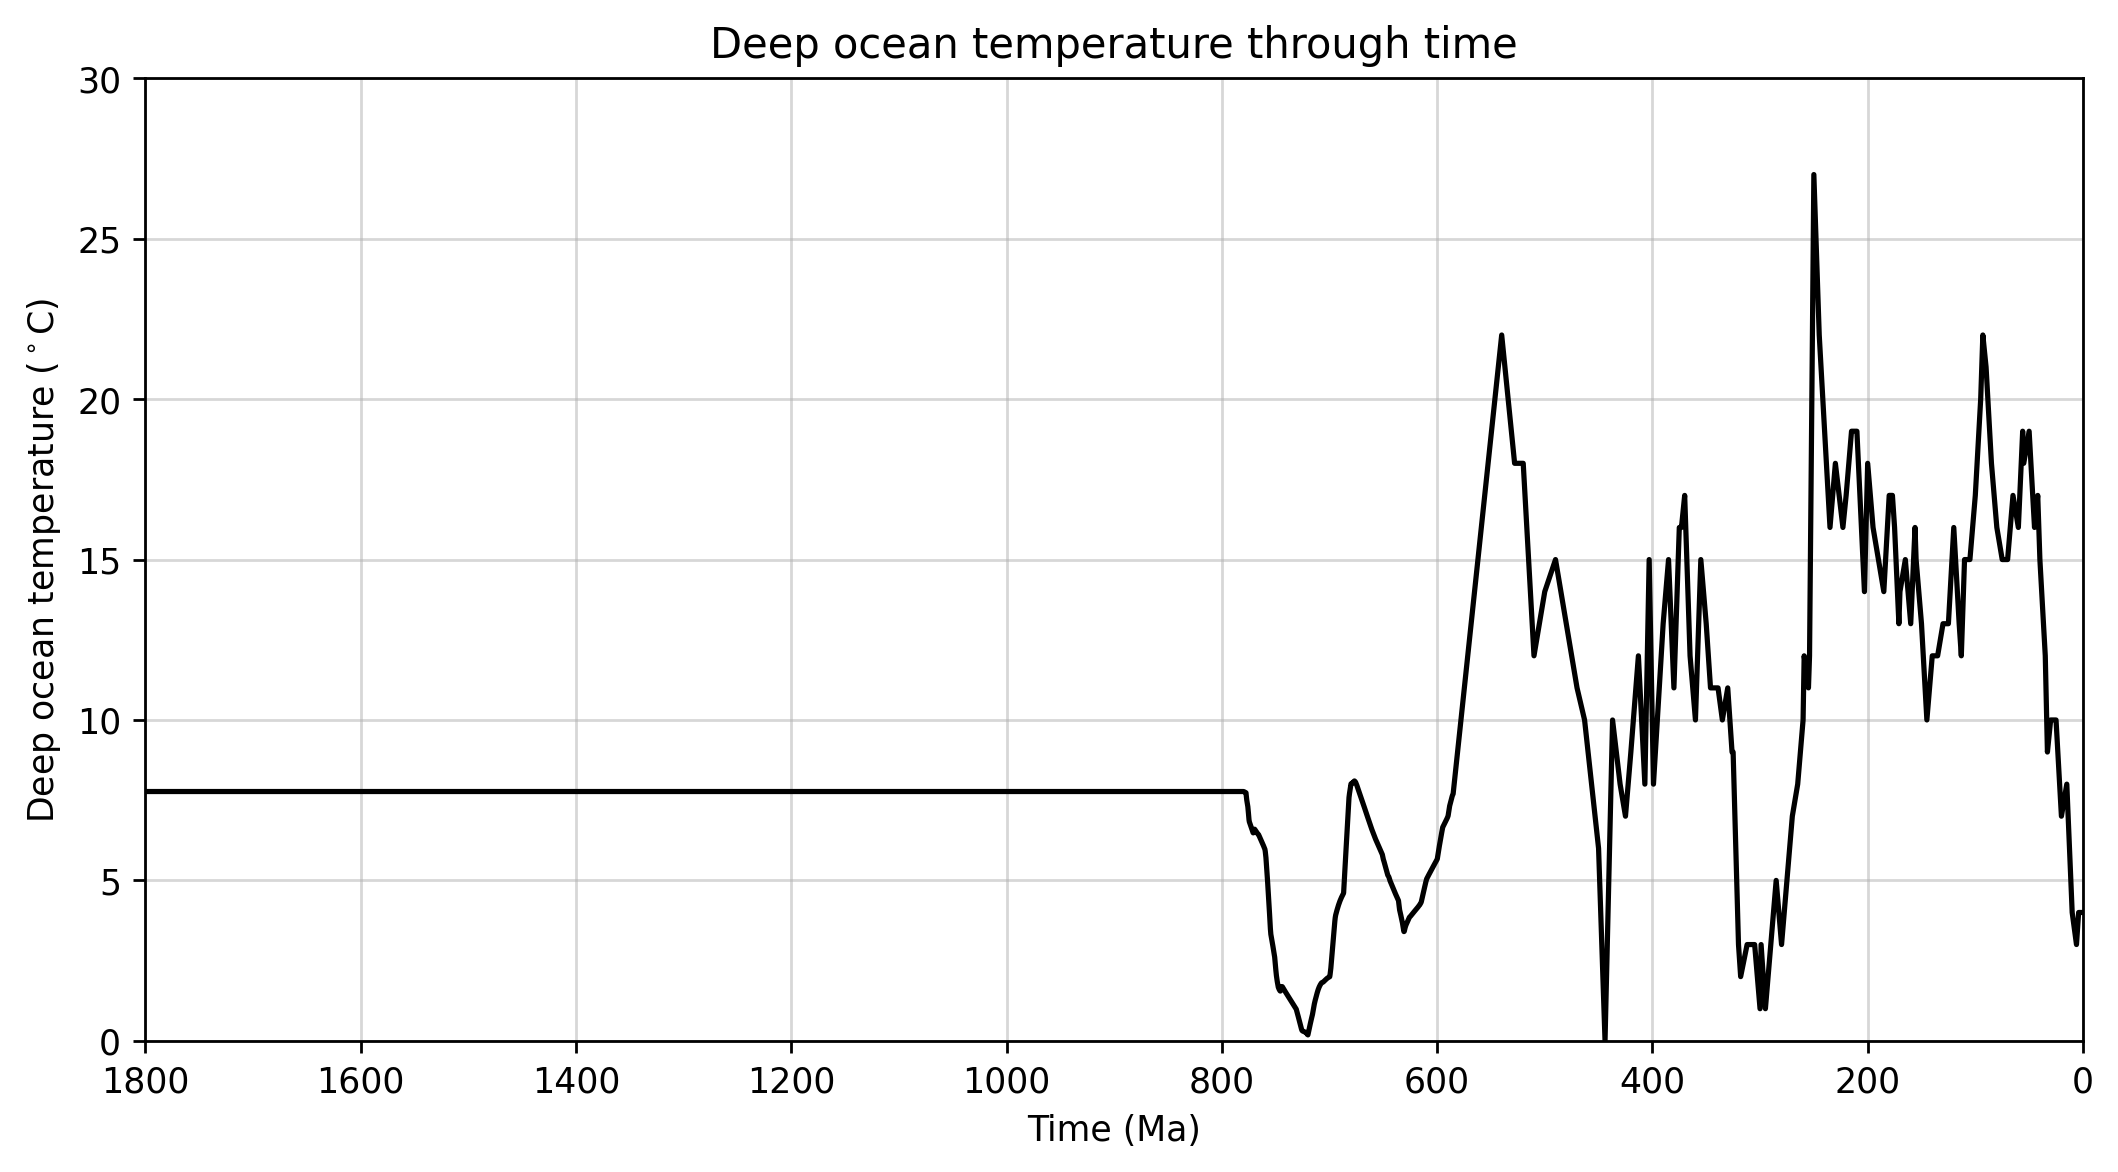

In [6]:
pd.read_table(age_temp_series_path)

temp_df = pd.read_table(age_temp_series_path, names=["Age", "DeepOceanTemp", "NaNs"]).iloc[1:].astype(float)
temp_df = temp_df.iloc[:, temp_df.columns != 'NaNs']

ages = temp_df['Age'].to_numpy()
ocean_temp = temp_df['DeepOceanTemp'].to_numpy()

# Extend the bottom water temperature plot to 1.8Ga by assuming that the temperature at 1Ga is constant.
Cao_extension = np.arange(1000,max_time,1)
Cao_temps = np.ones((len(Cao_extension)))*ocean_temp[-1]

ages = np.concatenate((ages, Cao_extension))
ocean_temp = np.concatenate((ocean_temp, Cao_temps))
# smoothed_ocean_temp = gplately.tools.smooth_1D_gaussian(ocean_temp,15)

fig = plt.figure(figsize=(10,5), dpi=250)
plt.plot(ages, ocean_temp, color='k')
plt.xlim([max_time,0])
plt.ylim([0,30])
plt.grid(alpha=0.5)
plt.title("Deep ocean temperature through time")
plt.xlabel("Time (Ma)")
plt.ylabel("Deep ocean temperature ($^\circ$C)")
plt.show()

save_fig = True
if save_fig:
    fig.savefig(fig_dir+"/figures/deep_ocean_temp.pdf", bbox_inches='tight', dpi=300)
    fig.savefig(fig_dir+"/figures/deep_ocean_temp.svg", bbox_inches='tight', dpi=300)
    fig.savefig(fig_dir+"/figures/deep_ocean_temp.png", bbox_inches='tight', dpi=300)

### Produce min, mean and max crustal carbon grids
This uses joblib's LokyBackend three times to produce grids for each of the three quantities: `min`, `mean` and `max`.

In [7]:
for mode in ["min", "mean", "max"]:
    Parallel(n_jobs=-1, verbose=1)(
        delayed(create_co2_grid)(reconstuction_time,
        age_temp_series_path,
        agegrid_path.format(reconstuction_time),
        co2_water_temperature_lookup_table_path.format(mode),
        output_path,
        mode,
        average_time_range) for reconstuction_time in reconstruction_times)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   18.4s
/Users/lila0720/micromamba/envs/env_gplately/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.7min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  4.1min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  7.9min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed: 13.2min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed: 19.8min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1801 out of 1801 | elapsed: 20.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   16.5s



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.6min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  3.9min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  7.6min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed: 12.8min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed: 19.4min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1801 out of 1801 | elapsed: 19.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   15.6s



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.6min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  3.8min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:  7.6min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1230 tasks      | elapsed: 12.8min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1780 tasks      | elapsed: 19.3min



##################################################################################################

            You are using a DEV version (1.3.0.post143+git.fadc3f73.dirty) GPlately.     
            Some functionalities in the DEV version have not been tested thoroughly, 
            and may break your code or produce wrong results due to 
            its unstable nature(DEV in progress). Proceed With Caution!!!
            You might also need to install the DEV version plate_model_manager 
            from https://github.com/michaelchin/plate-model-manager.

            To disable this warning, set USING_DEV_VERSION to False in __init__.py or
            set DISABLE_GPLATELY_DEV_WARNING environment variable to true.

            `export DISABLE_GPLATELY_DEV_WARNING=true`
            
            If you prefer not seeing this warning always, you may set the environment variable 
            in your boot scripts, such as .bashrc, .profile, autoexec.bat, etc.
            
###########

[Parallel(n_jobs=-1)]: Done 1801 out of 1801 | elapsed: 19.6min finished


Plot 1x min, mean and max grid to check how they look:

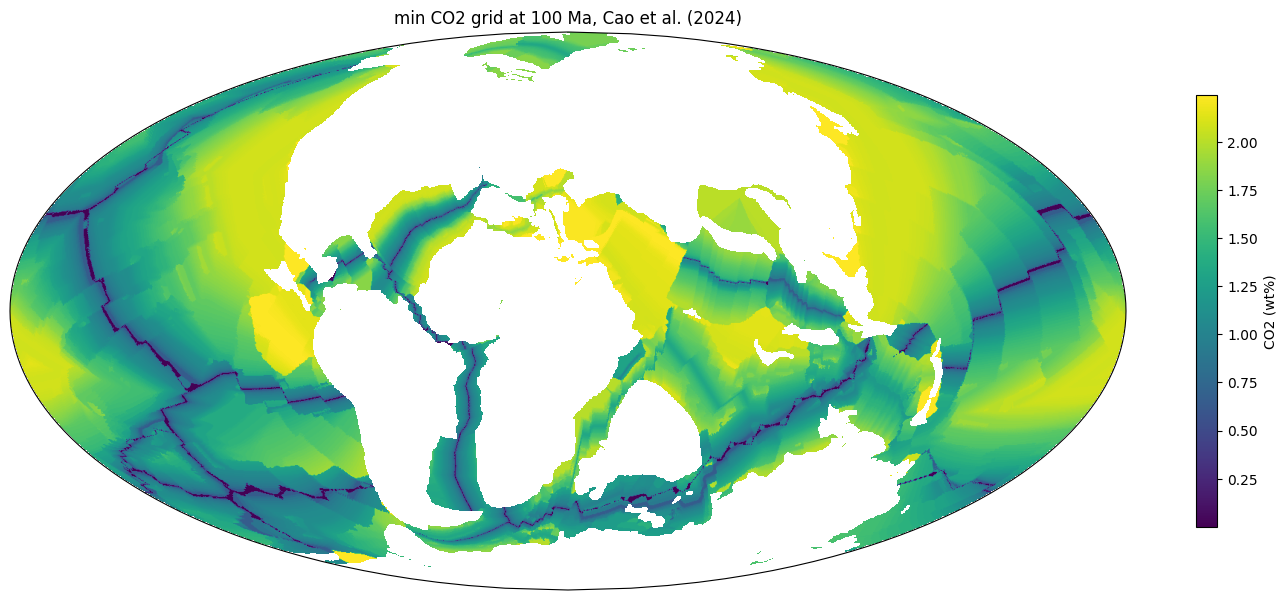

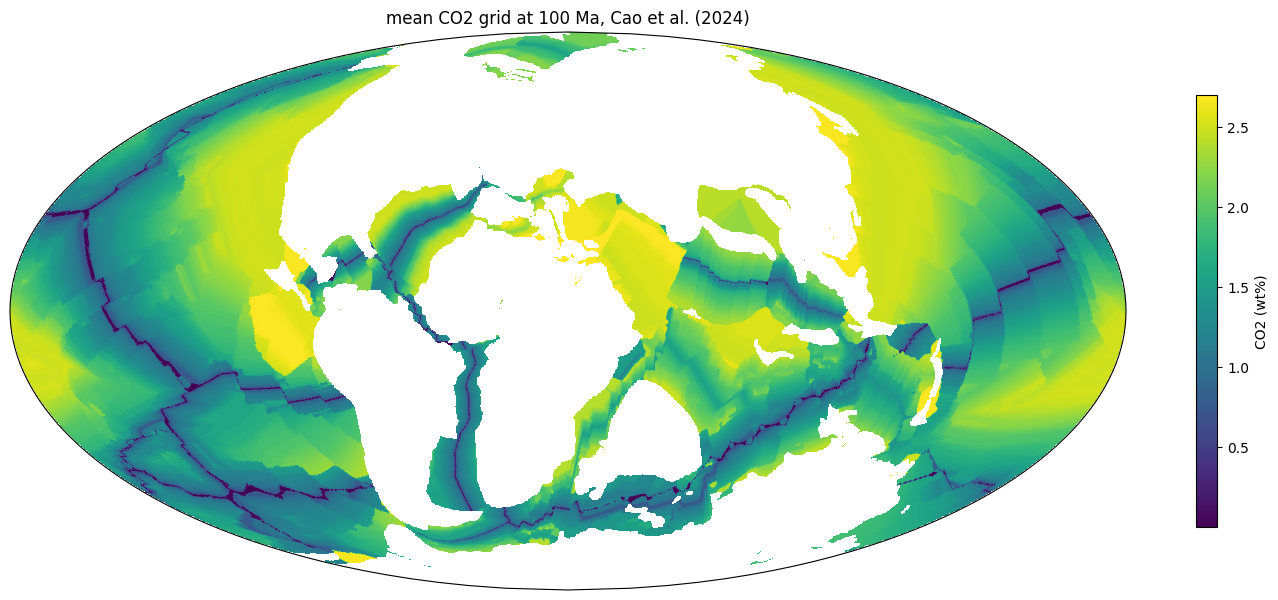

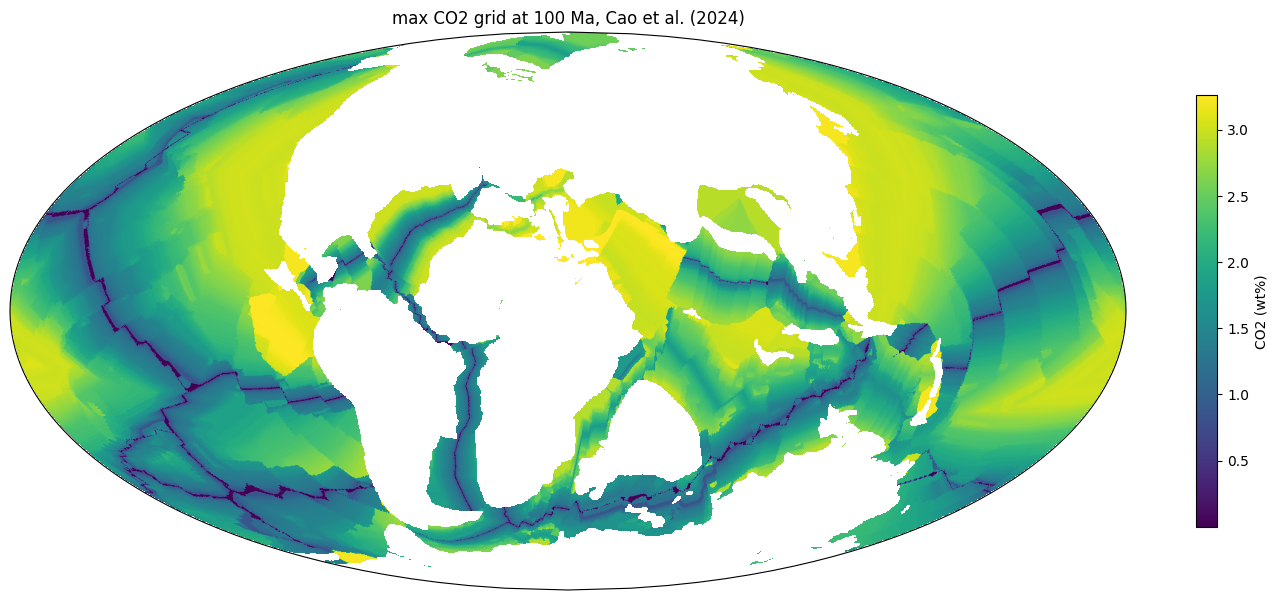

In [9]:
# Set up plot
crustalgrid_path = output_path+"/{}/{}/upper_crustal_CO2_{}_{}.nc"

def plot_crustal_carbon(crustalgrid_path, time):
    
    fig = plt.figure(figsize=(18,14), dpi=100)
    ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude = 20))
    ax1.set_title("{} CO2 grid at {} Ma, Cao et al. (2024)".format(mode, time))
    
    im = plt.imshow(
        gplately.grids.Raster(filename=crustalgrid_path.format(mode, time, mode, time)).data,
        origin="lower", transform=ccrs.PlateCarree()
    )
    
    fig.colorbar(im, shrink=0.4, label='CO2 (wt%)')
    
    ax1.set_global()
    
    # plt.savefig(output_path+"/{}/upper_crustal_CO2_{}.png".format(time, time))
    return


for mode in ["min", "mean", "max"]:
    for time in [100]:
        plot_crustal_carbon(crustalgrid_path.format(mode, time, mode, time), time)